# Heat Waves
---

In the end of April 2025, Western European countries experienced unseasonably warm weather. This example shows analysis of the selected parameters:
- [`z`](https://codes.ecmwf.int/grib/param-db/129) geopotential at constant pressure level 500 hPa, and
- [`t`](https://codes.ecmwf.int/grib/param-db/130) temperature at 850 hPa of the **AIFS-Single** datasets;
- [`2t`](https://codes.ecmwf.int/grib/param-db/167) 2 metre temperature,
- [`mn2t3`](https://codes.ecmwf.int/grib/param-db/228027) minimum temperature at 2 metres in the last 3 hours, and
- [`mx2t3`](https://codes.ecmwf.int/grib/param-db/228026) maximum temperature at 2 metres in the last 3 hours of the **IFS** datasets on 30 April at 12 UTC in France (48.3° N, 4.1° E).

:::{note}
In case of AIFS-Single datasets, [geopotential height](https://codes.ecmwf.int/grib/param-db/156) will be calculated from geopotential, because this parameter is not part of the AIFS products.
:::

## 1. Set Up Your Environment and Find ECMWF Open Data
Open data will be downloaded from a publicly available [Amazon S3 Bucket](../datadownload/find-data.ipynb). First, the following Python libraries need to be installed in the current Jupyter kernel:
- `ecmwf-opendata` to download data and
- `earthkit` to analyse and plot the data.

:::{seealso}
More detailed information about how to install Python packages is available on the [Retrieve Data](../datadownload/data-download.ipynb) website.
:::
If the packages are not installed yet, uncomment the code below and run it.

In [14]:
# !pip3 install earthkit ecmwf-opendata matplotlib

In [78]:
from ecmwf.opendata import Client
import earthkit.data as ekd
import earthkit.plots as ekp

import matplotlib.pyplot as plt

(content:references:labels)=
### List of parameters to retrieve from open datasets
The selected values below can be modified.

In [79]:
PARAM_SFC = ["mn2t3", "mx2t3", "2t"]
PARAM_PL = ["z", "t"] # "gh"
LEVELS = [500, 850]
LEVELTYPE = "sfc" # "pl", "sfc"

DATES = [20250429, 20250430, 20250501]
TIME = 0
STEPS = 12
STREAM = "oper" # "oper", "scda", "enfo"
TYPE = "fc" # "fc", "cf"
MODEL = "ifs" # "ifs", "aifs-single", "aifs-ens"

### Get the data using the ECMWF Open Data API

In [80]:
def get_open_data(date, time, step, stream, _type, model, param, leveltype, levelist=[]):
    client = Client(source="aws")
    list_of_files = []
    # Get the data for all dates
    for _date in DATES:
        filename = f"{model}_{''.join(param)}_{''.join(map(str, levelist))}_{_date}.grib2" if levelist else f"{model}_{''.join(param)}_{leveltype}_{_date}.grib2"
        data = client.retrieve(
            date=_date,
            time=time,
            step=step,
            stream=stream,
            type=_type,
            levtype=leveltype,
            levelist=levelist,
            param=param,
            model=model,
            target=filename
            )
        list_of_files.append(filename)
    return data, list_of_files

## 2. Geopotential at 500 hPa and temperature at 850 hPa
When using `ls()` function, a list of all the fields in the file we downloaded will be displayed.

In [68]:
data, list_of_files = get_open_data(date=DATES, time=TIME, step=STEPS, stream=STREAM, _type=TYPE, model=MODEL, param=PARAM_PL, leveltype=LEVELTYPE, levelist=LEVELS)

# Select AIFS model data from 29 April 2025
ds = ekd.from_source("file", list_of_files[0])
ds.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,z,isobaricInhPa,850,20250429,0,0,fc,None,regular_ll
1,ecmf,z,isobaricInhPa,500,20250429,0,0,fc,None,regular_ll
2,ecmf,t,isobaricInhPa,850,20250429,0,0,fc,None,regular_ll
3,ecmf,t,isobaricInhPa,500,20250429,0,0,fc,None,regular_ll


Only the parameters and their levels which we specified above will be returned when we apply the `sel()` function.

In [36]:
t850 = ds.sel({"level": 850, "shortName": "t"})
t850.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,t,isobaricInhPa,850,20250429,0,0,fc,None,regular_ll


In the cell below, the geopotential on 500 hPa is selected and a new fieldlist with a single field containing the new values and metadata is created. 
:::{tip}
See another example on how to [use the metadata object on the GRIB data](https://earthkit-data.readthedocs.io/en/latest/examples/grib_metadata_object.html#The-metadata-object).
:::

In [61]:
z500 = ds.sel({"level": 500, "shortName": "z"})[0]
z500.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,z,isobaricInhPa,500,20250429,0,0,fc,None,regular_ll


To change metadata values, put key value pairs to the `override()` function.

In [65]:
md_gh500 = z500.metadata().override(shortName="gh")
md_gh500["shortName"], md_gh500["level"]

('gh', 500)

Geopotential height is calculated by dividing the geopotential by the Earth's mean gravitational acceleration, g (=9.80665 m s-2). In the ECMWF Open Charts, it is plotted in geopotential decameters. Therefore, our result also need to be divided by 10.

In [95]:
ds_gh500 = z500.values / (9.80665 * 10)
gh500 = ekd.FieldList.from_array(ds_gh500, md_gh500)
gh500.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,gh,isobaricInhPa,500,20250429,0,0,fc,None,regular_ll


## 3. 2-metre temperature
The input values can be set [here](#content:references:labels).

- IFS model

In [81]:
data, list_of_files = get_open_data(date=DATES, time=TIME, step=STEPS, stream=STREAM, _type=TYPE, model=MODEL, param=PARAM_SFC, leveltype=LEVELTYPE, levelist=[])

# Select data from 30 April 2025
ds_2t = ekd.from_source("file", list_of_files[1])
ds_2t.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,mx2t3,heightAboveGround,2,20250430,0,9-12,fc,None,regular_ll
1,ecmf,mn2t3,heightAboveGround,2,20250430,0,9-12,fc,None,regular_ll
2,ecmf,2t,heightAboveGround,2,20250430,0,12,fc,None,regular_ll


There is no need to convert temperature from Kelvin to Celsius, because in the `earthkit-plots` library we can set units of it.

:::{important}
Some units of our data can be converted using `units` option, however, this is not possible for all of the parameters in the GRIB file. 
:::

In [81]:
t2m = ds_2t.sel(shortName="2t")
t2m.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,2t,heightAboveGround,2,20250430,0,12,fc,None,regular_ll


In [85]:
t2max_K = ds_2t.sel(shortName="mx2t3")[0]
t2max_K.metadata("units")

'K'

In [86]:
md_t2max = t2max_K.metadata().override(shortName="mx2t3")
ds_t2max = t2max_K.values - 273.15
t2max = ekd.FieldList.from_array(ds_t2max, md_t2max)
t2max.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,mx2t3,heightAboveGround,2,20250430,0,9-12,fc,None,regular_ll


In [87]:
t2min_K = ds_2t.sel(shortName="mn2t3")[0]
t2min_K.metadata("units")

md_t2min = t2min_K.metadata().override(shortName="mn2t3")
ds_t2min = t2min_K.values - 273.15
t2min = ekd.FieldList.from_array(ds_t2min, md_t2min)
t2min.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,mn2t3,heightAboveGround,2,20250430,0,9-12,fc,None,regular_ll


- AIFS model

In [110]:
data, list_of_files = get_open_data(date=DATES, time=TIME, step=STEPS, stream=STREAM, _type=TYPE, model=MODEL, param=PARAM_SFC, leveltype=LEVELTYPE, levelist=[])

# Select data from 30 April 2025
ds_2t_aifs = ekd.from_source("file", list_of_files[1])
t2m_aifs = ds_2t_aifs.sel(shortName="2t")
t2m_aifs.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,2t,heightAboveGround,2,20250430,0,12,fc,None,regular_ll


## 4. Data visualisation

We will plot our data from AIFS and IFS on the map defining our specific plotting methods.

In [71]:
def levels_str_int(contour_level_list):
    return [int(i) for i in contour_level_list.replace("/", ",").split(",")]

# https://github.com/ecmwf/magics/blob/master/share/magics/styles/ecmwf/styles.json
# contour_style_name = "sh_all_fM80t56i4"
contour_level_list="-80/-70/-60/-52/-48/-44/-40/-36/-32/-28/-24/-20/-16/-12/-8/-4/0/4/8/12/16/20/24/28/32/36/40/44/48/52/56"
_levels = levels_str_int(contour_level_list)

The plot below shows analysis of T850 and z500 on 29 April 2025.

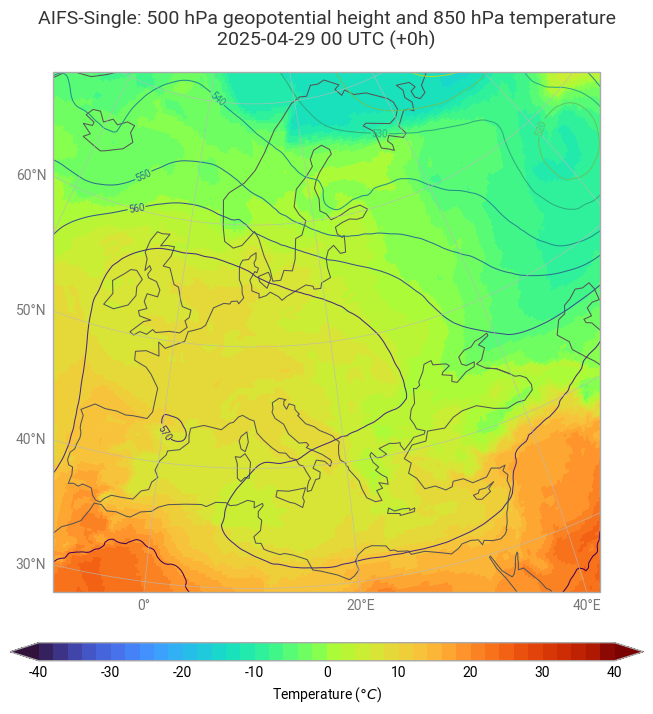

In [69]:
chart = ekp.Map(domain="Europe")

t850_shade = ekp.styles.Style(
    colors=values_to_colors(["rgb(1,1,1)/rgb(0.9,0.9,0.9)/rgb(0.8,0.8,0.8)/rgb(0.7,0.7,0.7)/rgb(0.68,0.6,0.68)/rgb(0.48,0.4,0.48)/rgb(0.28,0.2,0.28)/rgb(0.2,0,0.4)/rgb(0.35,0,0.5)/blue_purple/greenish_blue/rgb(0,0.8,1.0)/blue_green/rgb(0.15,0.9,0.6)/rgb(0.4,0.75,0.15)/rgb(0.75,0.9,0.15)/rgb(1,1,0.5)/yellow/orange_yellow/yellowish_orange/rgb(1,0.45,0)/red/rgb(0.8,0,0)/burgundy/rose/magenta/rgb(1,0.5,1)/rgb(1,0.75,1)/rgb(0.9,0.8,0.9)/rgb(0.9,0.9,0.9)"]),
    levels=_levels,
    units="celsius",
)

gh500_shade = ekp.styles.Style(
    colors="ct_blk_i4_t2",
    legend_style=None,
    units="gpd",
)

chart.grid_cells(t850, units="celsius", auto_style=True) #, style=t850_shade)
chart.contour(gh500, legend_style="None") #, style=gh500_shade)

chart.coastlines(resolution="low")
chart.gridlines()

chart.legend(location="bottom", label="{variable_name} ({units})")

chart.title(
    "AIFS-Single: 500 hPa geopotential height and 850 hPa temperature\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)
plt.savefig("ghT_aifs_20250429000000-0h.png")
chart.show()

The plots below show analyses of 2 metre temperature, minimum, and maximum temperature at 2 metres in the last 3 hours on 30 April at 00 UTC.

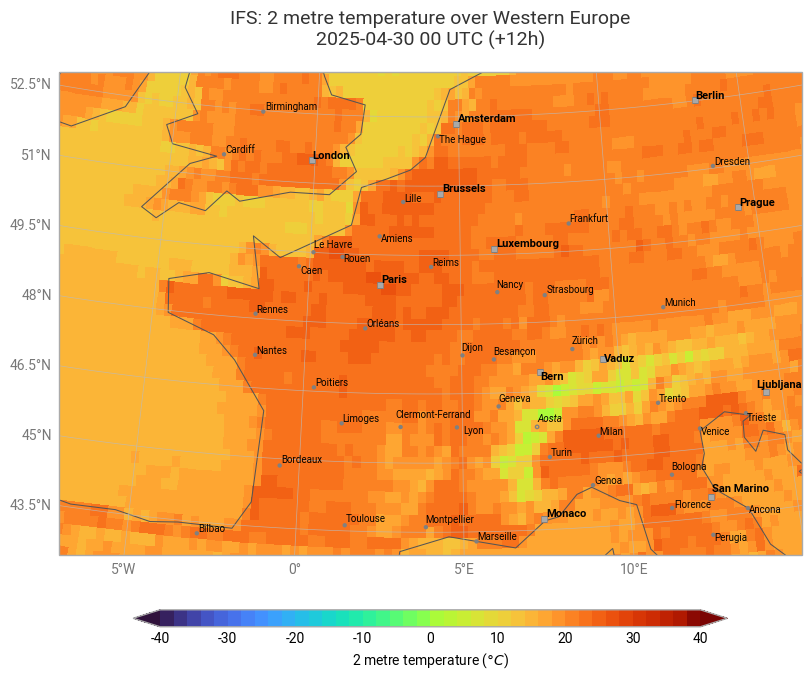

In [108]:
chart = ekp.Map(domain=[-7, 15, 43, 53])

chart.grid_cells(t2m, units="celsius", auto_style=True)

chart.title(
    "IFS: {variable_name} over Western Europe\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)

chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(adjust_labels=True)

chart.legend(location="bottom", label="{variable_name} ({units})")

plt.savefig("t2m_ifs_20250430000000-12h.png")
chart.show()

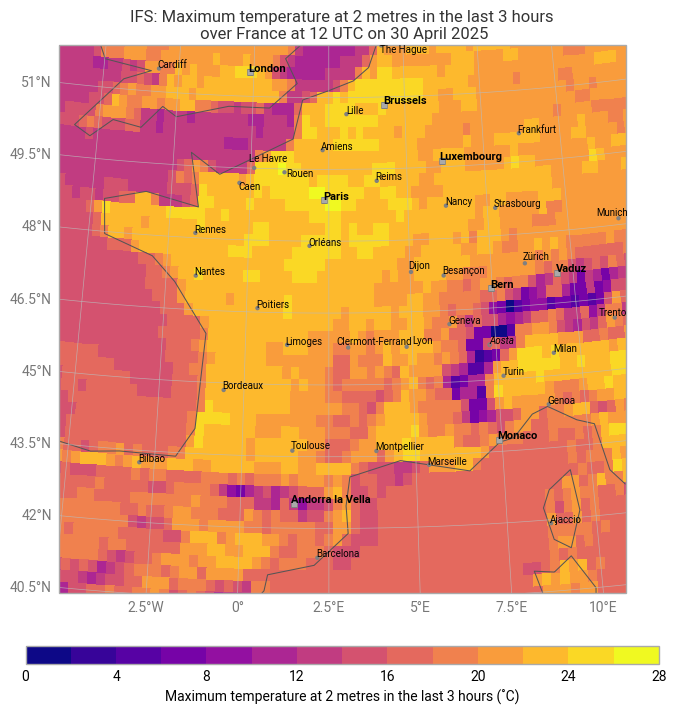

In [91]:
chart = ekp.Map(domain="France")

chart.grid_cells(t2max, auto_style=True)

chart.title("IFS: {variable_name}\n over {domain} at {time:%H UTC on %-d %B %Y}")

chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(adjust_labels=True)

chart.legend(location="bottom", label="{variable_name} (˚C)")

plt.savefig("./plots/t2max_ifs_20250430000000-12h.png")
chart.show()

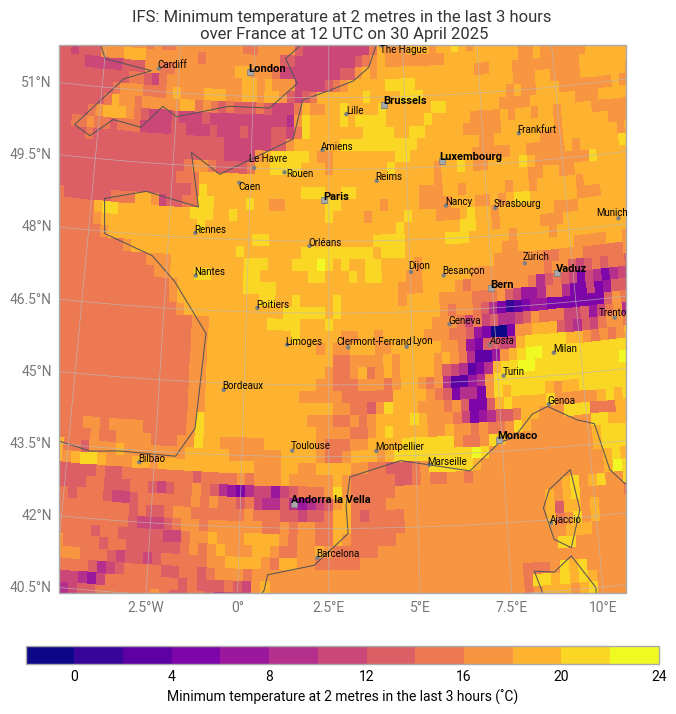

In [90]:
chart = ekp.Map(domain="France")

chart.grid_cells(t2min, auto_style=True)

chart.title("IFS: {variable_name}\n over {domain} at {time:%H UTC on %-d %B %Y}")

chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(adjust_labels=True)

chart.legend(location="bottom", label="{variable_name} (˚C)")

plt.savefig("./plots/t2min_ifs_20250430000000-12h.png")
chart.show()

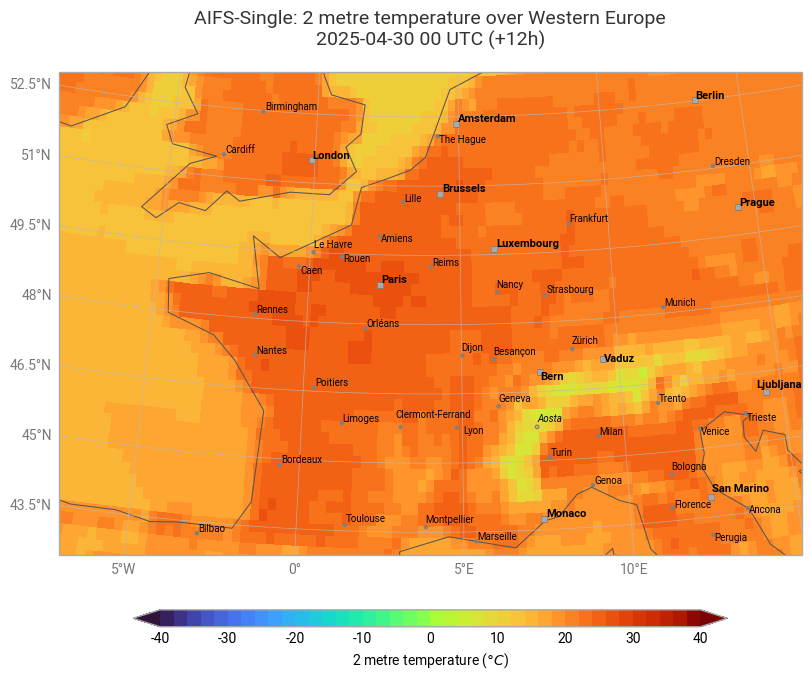

In [111]:
chart = ekp.Map(domain=[-7, 15, 43, 53])

chart.grid_cells(t2m_aifs, units="celsius", auto_style=True)

chart.title(
    "AIFS-Single: {variable_name} over Western Europe\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)

chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(adjust_labels=True)

chart.legend(location="bottom", label="{variable_name} ({units})")

plt.savefig("t2m_aifs_20250430000000-12h.png")
chart.show()

::::{dropdown} IFS Control Forecast
In the short-range forecasts on 30 April 2025, one can see the sign of a heat-island over Paris and London.

```python
from ecmwf.opendata import Client
import earthkit.data as ekd
import earthkit.plots as ekp
```

```python
PARAM_SFC = "2t"
PARAM_PL = []
LEVELS = []
LEVELTYPE = "sfc"

DATES = 20250430
TIME = 12
STEPS = [0, 48, 72, 120]
STREAM = "enfo"
TYPE = "cf"
MODEL = "ifs"
```

```python
def get_open_data(date, time, step, stream, _type, model, param, leveltype, levelist=[]):
    client = Client(source="aws")
    # Get the data for all steps
    filename = f"{model}_{''.join(param)}_{date}_{'-'.join(map(str, step))}.grib2"
    data = client.retrieve(
        date=date,
        time=time,
        step=step,
        stream=stream,
        type=_type,
        levtype=leveltype,
        levelist=levelist,
        param=param,
        model=model,
        target=filename
        )
    return data, filename
```

```python
data, filename = get_open_data(date=DATES, time=TIME, step=STEPS, stream=STREAM, _type=TYPE, model=MODEL, param=PARAM_SFC, leveltype=LEVELTYPE, levelist=[])

ds_ifs = ekd.from_source("file", filename)
t2m_ifs = ds_ifs.sel(shortName="2t")
t2m_ifs.ls()
```

```python
figure = ekp.Figure(domain=[-7, 15, 43, 53], size=(9, 9), rows=2, columns=4)

for i in range(4):
    figure.add_map(1+i//4, i%4)

figure.contourf(t2m_ifs, units="celsius", auto_style=True)

figure.coastlines()
figure.gridlines()

figure.legend(label="{variable_name} ({units})")

figure.subplot_titles("{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)")
figure.title(
    "IFS (Control Forecast): {base_time:%Y-%m-%d %H} UTC\n {variable_name} over Western Europe\n\n",
    fontsize=14, horizontalalignment="center",
)
figure.save(fname=f"./plots/{PARAM_SFC}_{MODEL}_{DATES}{TIME}-{'-'.join(map(str, STEPS))}h.png")
figure.show()
```

:::{figure} ./plots/2t_ifs_2025043012-0-48-72-120h.png
:label: fig:ifs-ens
:::

:::{seealso}
Additional information about a `Figure` can be found [here](https://earthkit-plots.readthedocs.io/en/stable/_api/figures/index.html) .
:::

Compared to the IFS Control Forecast, one can note that the event was well captured by the IFS model from 30 April and onwards.

```python
filename_fc="ifs_2t_20250503120000-0h.grib2"

client = Client(source="aws")
client.retrieve(
    date=20250503,
    time=12,
    step=0,
    stream="oper",
    type="fc",
    levtype="sfc",
    param='2t',
    model="ifs",
    target=filename_fc
)
```

```python
ds_fc = ekd.from_source("file", filename_fc)
t2m_fc = ds_fc.sel(shortName="2t")
t2m_fc.ls()
```

```python
chart = ekp.Map(domain=[-7, 15, 43, 53])
chart.grid_cells(t2m_fc, units="celsius", auto_style=True)

chart.title(
    "IFS: {variable_name} over Western Europe\n"
    "on {time:%-d %B %Y at %H UTC}\n",
    fontsize=14, horizontalalignment="center",
)
chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(adjust_labels=True)

chart.legend(location="bottom", label="{variable_name} ({units})")

plt.savefig("./plots/ifs_2t_20250503120000-0h.png")
chart.show()
```
:::{figure} ./plots/ifs_2t_20250503120000-0h.png
:label: fig:ifs_fc
:::

::::